In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/oliwi/OneDrive/Pulpit/AutoML/Projekt1/AutoML/depression/depression_data.csv")
df.head()


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


Usuwamy pierwszą kolumnę z imionami/nazwiskami, bo nie chcemy, zeby model wiazal np. imie Adam z posiadaniem depresji
Dodatkowo sprawdzamy czy są wartości NULL

In [26]:
df = df.drop(columns="Name")

df.info() #413768 wierszow bez nulli
len(df) #liczba wierszy = 413768, czyli nie ma wierszy z brakujacymi informacjami

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           413768 non-null  int64  
 1   Marital Status                413768 non-null  object 
 2   Education Level               413768 non-null  object 
 3   Number of Children            413768 non-null  int64  
 4   Smoking Status                413768 non-null  object 
 5   Physical Activity Level       413768 non-null  object 
 6   Employment Status             413768 non-null  object 
 7   Income                        413768 non-null  float64
 8   Alcohol Consumption           413768 non-null  object 
 9   Dietary Habits                413768 non-null  object 
 10  Sleep Patterns                413768 non-null  object 
 11  History of Mental Illness     413768 non-null  object 
 12  History of Substance Abuse    413768 non-nul

413768

Podstawowe wykresy w celu analizy wartości odstających i anomalii

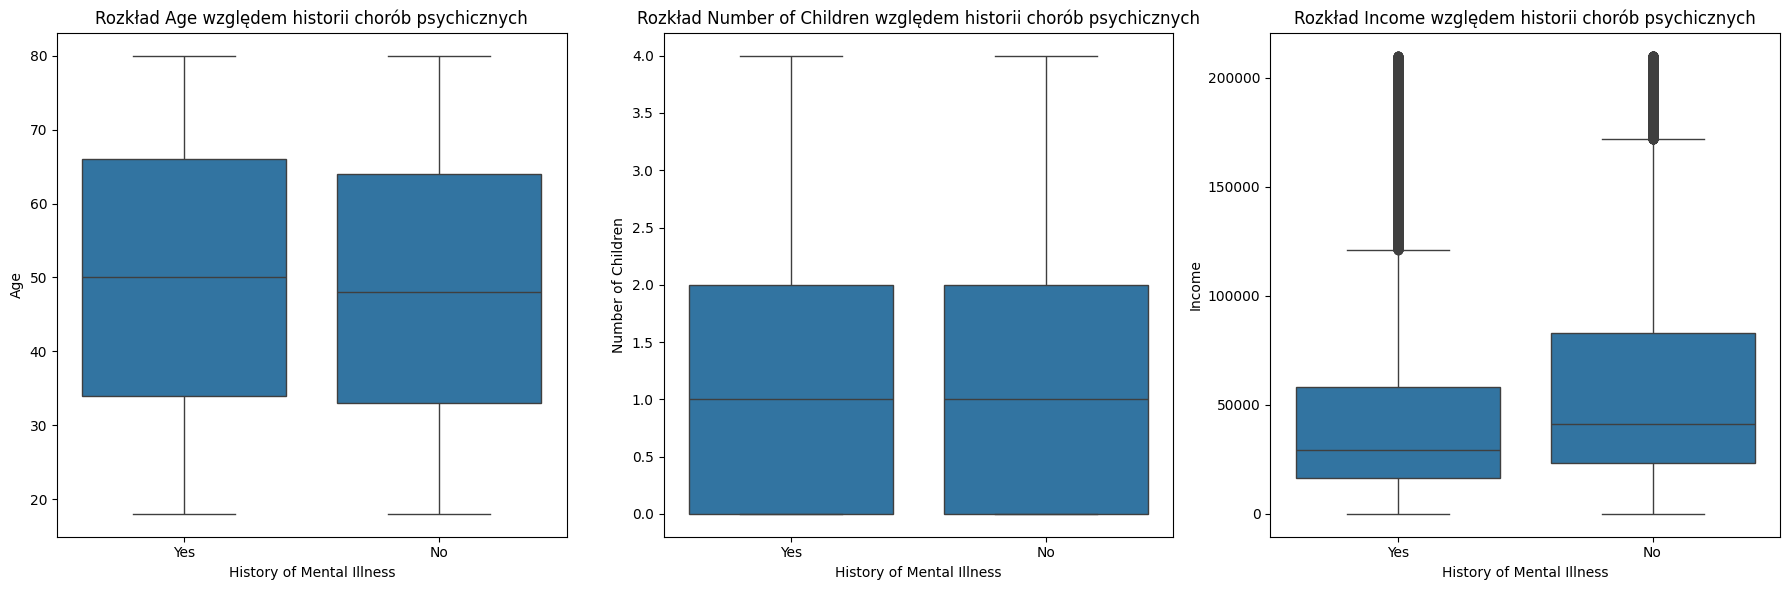

Rozkład dla Marital Status:
History of Mental Illness      No    Yes
Marital Status                          
Divorced                    23111   9618
Married                    167155  73289
Single                      50690  21420
Widowed                     46987  21498


Rozkład dla Education Level:
History of Mental Illness     No    Yes
Education Level                        
Associate Degree           53324  26675
Bachelor's Degree          89845  34484
High School                79583  39344
Master's Degree            53111  20657
PhD                        12080   4665


Rozkład dla Smoking Status:
History of Mental Illness      No    Yes
Smoking Status                          
Current                     35174  14994
Former                      81031  35153
Non-smoker                 171738  75678


Rozkład dla Physical Activity Level:
History of Mental Illness      No    Yes
Physical Activity Level                 
Active                      55424  23481
Moderate          

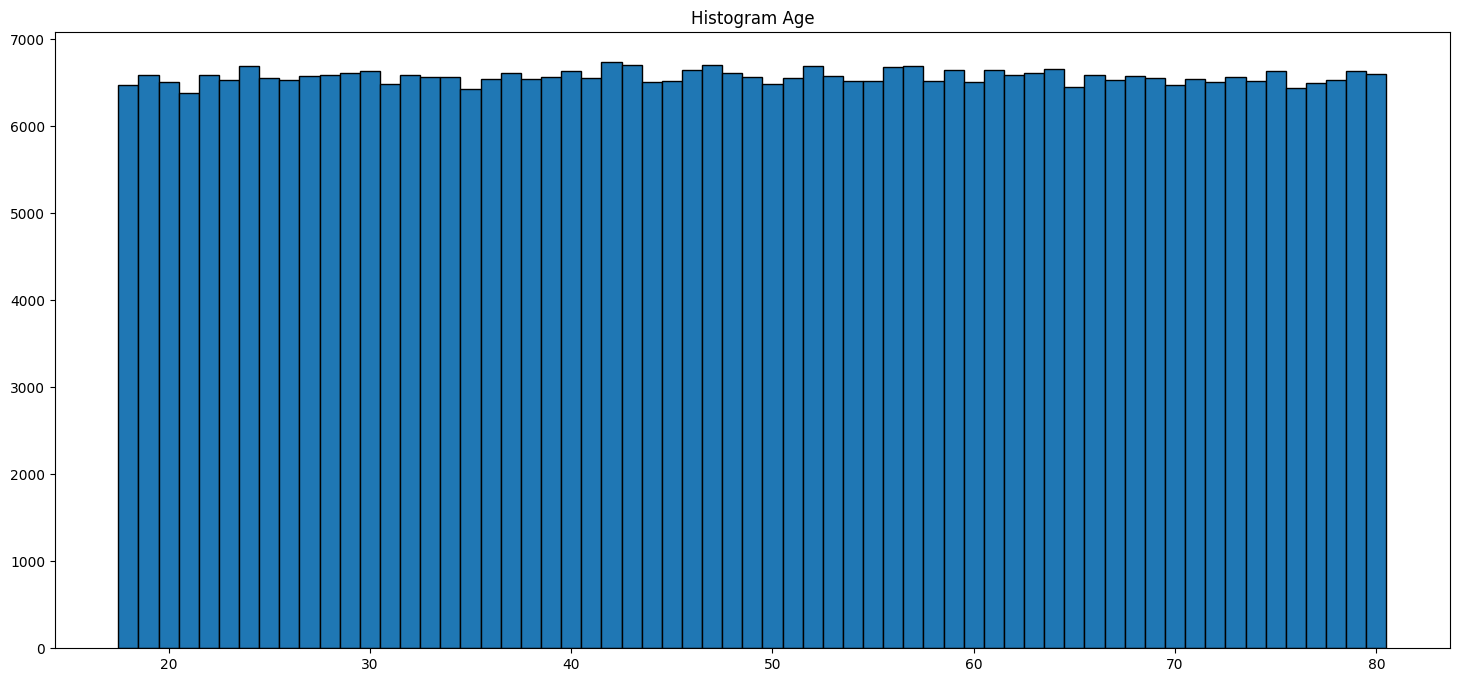

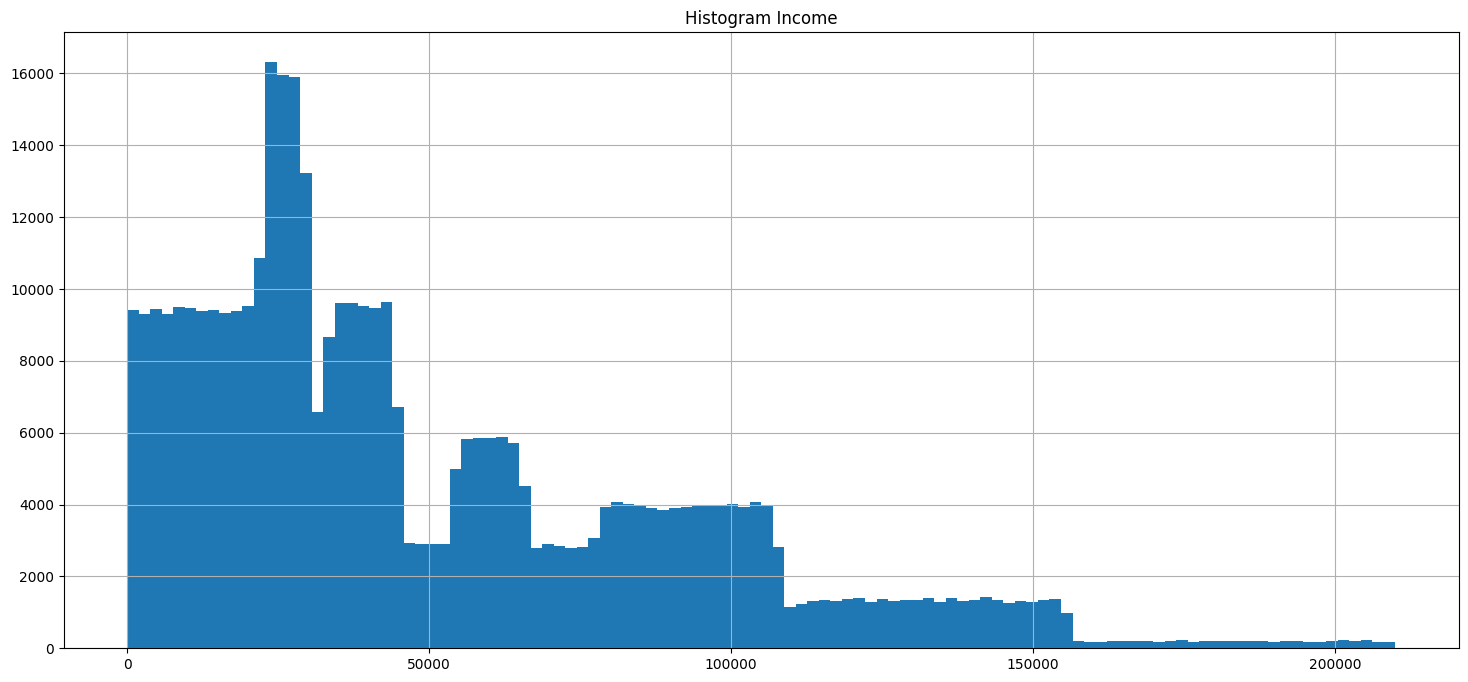

In [27]:
grouped = df.groupby('History of Mental Illness')
numeryczne_kolumny = ['Age', 'Number of Children', 'Income']

plt.figure(figsize=(18, 6))
for i, kolumna in enumerate(numeryczne_kolumny, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='History of Mental Illness', y=kolumna, data=df)
    plt.title(f'Rozkład {kolumna} względem historii chorób psychicznych')
plt.tight_layout()
plt.show()
kategoryczne_kolumny = ['Marital Status', 'Education Level', 'Smoking Status', 
                        'Physical Activity Level', 'Employment Status', 
                        'Alcohol Consumption', 'Dietary Habits', 
                        'Sleep Patterns', 'History of Substance Abuse', 
                        'Family History of Depression', 'Chronic Medical Conditions']

for col in kategoryczne_kolumny:
    print(f"Rozkład dla {col}:")
    print(pd.crosstab(df[col], df['History of Mental Illness']))
    print("\n")

# histogramy:
plt.figure(figsize=(18, 8))
plt.hist(df["Age"], bins=range(int(df["Age"].min()), int(df["Age"].max()) + 2), edgecolor='black', align='left')
plt.title(f'Histogram Age')
plt.show()

df["Income"].hist(bins=110, figsize=(18, 8))
plt.title(f'Histogram Income')
plt.show()

Usuwanie wartości odstających
Tworzenie nowych kolumn - income group, w ktorej income jest podzielony na przedzialy co 1000

In [28]:
print('Usuwanie outlierów w kolumnie Income')
bins = range(0, int(df['Income'].max()) + 1000, 1000)  # Przedziały co 1000
labels = [f'{x}-{x+999.99}' for x in bins[:-1]]  # Tworzymy etykiety przed
df['Income Group'] = pd.cut(df['Income'], bins=bins, labels=labels, right=False)
income_group_counts = df['Income Group'].value_counts().sort_index()
filtered_income_groups = income_group_counts[income_group_counts < 500].index
input_size = df.shape[0]
df_filtered = df[~df['Income Group'].isin(filtered_income_groups)]
output_size = df_filtered.shape[0]
removed_rows = input_size - output_size

print(f'Wejściowy rozmiar ramki danych: {input_size} wierszy')
print(f'Wyjściowy rozmiar ramki danych: {output_size} wierszy')
print(f'Liczba usuniętych wierszy: {removed_rows} wierszy')

print("Przedziały dochodów, gdzie liczba wystąpień jest mniejsza niż 1000:")
print(income_group_counts[income_group_counts < 500])

exclude_columns = ["Age", "Income", "Number of Children"]
print()
print('Analiza outlierów w kolumnach kategorycznych')
for col in df.columns:
    if col not in exclude_columns:
        print(f"Kolumna: {col}")
        counts = df[col].value_counts(dropna=False)
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100
        result = pd.concat([counts, percentages], axis=1, keys=["Liczba", "Procent"])
        print(result)
        print("-" * 40)

Usuwanie outlierów w kolumnie Income
Wejściowy rozmiar ramki danych: 413768 wierszy
Wyjściowy rozmiar ramki danych: 408193 wierszy
Liczba usuniętych wierszy: 5575 wierszy
Przedziały dochodów, gdzie liczba wystąpień jest mniejsza niż 1000:
Income Group
156000-156999.99    111
157000-157999.99     98
158000-158999.99    107
159000-159999.99    101
160000-160999.99     93
161000-161999.99     94
162000-162999.99    108
163000-163999.99    109
164000-164999.99    105
165000-165999.99    103
166000-166999.99    124
167000-167999.99     98
168000-168999.99    109
169000-169999.99    110
170000-170999.99     97
171000-171999.99     83
172000-172999.99     98
173000-173999.99    124
174000-174999.99    105
175000-175999.99    104
176000-176999.99    106
177000-177999.99     98
178000-178999.99    109
179000-179999.99    100
180000-180999.99    106
181000-181999.99     92
182000-182999.99    108
183000-183999.99    104
184000-184999.99    117
185000-185999.99     99
186000-186999.99    106
1870

Zamiana zmiennych kategorycznych na numeryczne 

In [29]:
# ordinal encoding - skala
activity_mapping = {
    "Sedentary": 0,
    "Moderate": 1,
    "Active": 2,
}
if "Physical Activity Level" in df.columns:
    df["Physical Activity Level"] = df["Physical Activity Level"].map(activity_mapping)

alcohol_mapping = {
    "Low": 0,
    "Moderate": 1,
    "High": 2,
}
if "Alcohol Consumption" in df.columns:
    df["Alcohol Consumption"] = df["Alcohol Consumption"].map(alcohol_mapping)

dietary_mapping = {
    "Unhealthy": 0,
    "Moderate": 1,
    "Healthy": 2,
}
if "Dietary Habits" in df.columns:
    df["Dietary Habits"] = df["Dietary Habits"].map(dietary_mapping)

sleep_mapping = {
    "Poor": 0,
    "Fair": 1,
    "Good": 2,
}
if "Sleep Patterns" in df.columns:
    df["Sleep Patterns"] = df["Sleep Patterns"].map(sleep_mapping)

#one hot encoding - 0,1
binary_cols = [
    "History of Substance Abuse",
    "History of Mental Illness",
    "Family History of Depression",
    "Chronic Medical Conditions"
]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].str.strip().map({"Yes": 1, "No": 0})

employment_mapping = {
    "Unemployed": 0,
    "Employed": 1
}
if "Employment Status" in df.columns:
    df["Employment Status"] = df["Employment Status"].map(employment_mapping)

education_mapping = {
    "High School": 0,
    "Associate Degree": 1,
    "Bachelor's Degree": 1,
    "Master's Degree": 1,
    "PhD": 1
}
if "Education Level" in df.columns:
    df["Education Level"] = df["Education Level"].map(education_mapping)    


df["Married"] = (df["Marital Status"] == "Married").astype(int)
df["Single"] = (df["Marital Status"] == "Single").astype(int)
df["Widowed"] = (df["Marital Status"] == "Widowed").astype(int)
df.drop(columns=["Marital Status"], inplace=True)

df["Non-smoker"] = (df["Smoking Status"] == "Non-smoker").astype(int)
df["Former"] = (df["Smoking Status"] == "Former").astype(int)
df["Current"] = (df["Smoking Status"] == "Current").astype(int)
df.drop(columns=["Smoking Status"], inplace=True)

df.head()




,Age,Education Level,Number of Children,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,Income Group,Married,Single,Widowed,Non-smoker,Former,Current
0,31,1,2,2,0,26265.67,1,1,1,1,0,1,1,26000-26999.99,1,0,0,1,0,0
1,55,0,1,0,1,42710.36,2,0,1,1,0,0,1,42000-42999.99,1,0,0,1,0,0
2,78,1,1,0,1,125332.79,0,0,2,0,0,1,0,125000-125999.99,0,0,1,1,0,0
3,58,1,3,1,0,9992.78,1,1,0,0,0,0,0,9000-9999.99,0,0,0,1,0,0
4,18,0,0,0,0,8595.08,0,1,1,1,0,1,1,8000-8999.99,0,1,0,1,0,0


wiek - podzial na grupy 0-18, 19-30, 31-40, 41-50, 51-60, 61-70, 71-90
Normalizacja zmiennej Age - bo byl rozklad jednostajny

In [30]:
from sklearn.preprocessing import MinMaxScaler
 
bins = [0, 18, 30, 40, 50, 60, 70, 90]
labels = [0, 1, 2, 3, 4, 5, 6] 
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Age Group'] = df['Age Group'].astype(int)

scaler = MinMaxScaler()
df['Age Group Normalized'] = scaler.fit_transform(df[['Age Group']])
df.drop(columns=["Age Group"], inplace=True)
df.drop(columns=["Age"], inplace=True)
df.head()

,Education Level,Number of Children,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,Income Group,Married,Single,Widowed,Non-smoker,Former,Current,Age Group Normalized
0,1,2,2,0,26265.67,1,1,1,1,0,1,1,26000-26999.99,1,0,0,1,0,0,0.2
1,0,1,0,1,42710.36,2,0,1,1,0,0,1,42000-42999.99,1,0,0,1,0,0,0.6
2,1,1,0,1,125332.79,0,0,2,0,0,1,0,125000-125999.99,0,0,1,1,0,0,1.0
3,1,3,1,0,9992.78,1,1,0,0,0,0,0,9000-9999.99,0,0,0,1,0,0,0.6
4,0,0,0,0,8595.08,0,1,1,1,0,1,1,8000-8999.99,0,1,0,1,0,0,0.0


Logarytmiczne przekształcenie dochodu (log1p = log(1 + x), bezpieczne dla zera), bo histogram byl prawoskosny.
Dodatkowo standaryzacja przekształconego dochodu

,Education Level,Number of Children,Physical Activity Level,Employment Status,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,Married,Single,Widowed,Non-smoker,Former,Current,Age Group Normalized,Income_scaled
0,1,2,2,0,1,1,1,1,0,1,1,1,0,0,1,0,0,0.2,-0.213319
1,0,1,0,1,2,0,1,1,0,0,1,1,0,0,1,0,0,0.6,0.228157
2,1,1,0,1,0,0,2,0,0,1,0,0,0,1,1,0,0,1.0,1.205719
3,1,3,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0.6,-1.090830
4,0,0,0,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0.0,-1.227638


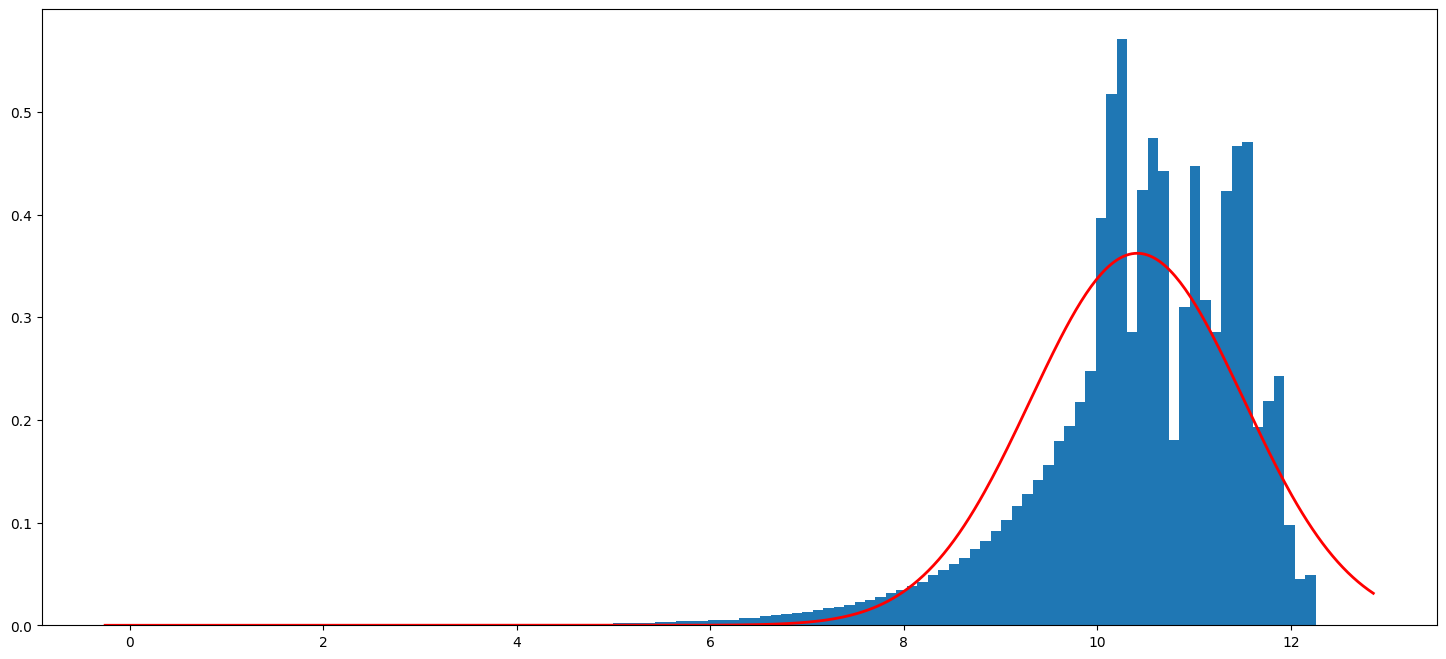

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

data = np.log1p(df['Income'])
mu, std = data.mean(), data.std()
plt.figure(figsize=(18, 8))
plt.hist(data, bins=110, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Krzywa Gaussa')

scaler = StandardScaler()
df['Income_scaled'] = scaler.fit_transform(data.values.reshape(-1, 1))
df.drop(columns=["Income"], inplace=True)
df.drop(columns=["Income Group"], inplace=True)

df.head()

In [32]:
df

,Education Level,Number of Children,Physical Activity Level,Employment Status,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,Married,Single,Widowed,Non-smoker,Former,Current,Age Group Normalized,Income_scaled
0,1,2,2,0,1,1,1,1,0,1,1,1,0,0,1,0,0,0.2,-0.213319
1,0,1,0,1,2,0,1,1,0,0,1,1,0,0,1,0,0,0.6,0.228157
2,1,1,0,1,0,0,2,0,0,1,0,0,0,1,1,0,0,1.0,1.205719
3,1,3,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0.6,-1.090830
4,0,0,0,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0.0,-1.227638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,1,0,1,1,0,2,2,0,0,0,0,1,0,0,0,1,0,0.8,1.080872
413764,1,0,2,1,0,2,0,1,1,0,1,0,1,0,0,0,1,0.0,0.970774
413765,1,0,0,1,1,1,1,0,0,1,1,1,0,0,1,0,0,0.6,0.767493
413766,1,2,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1.0,-0.274396


In [33]:
df.to_csv('depression_transformed.csv', index=False)